In [ ]:
import pandas as pd
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 
import matplotlib.colors as mcolors
import seaborn as sns
import numpy as np
import re
from wordcloud import WordCloud ,STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

### unzip and read training data

In [15]:
!unzip train.csv.zip

Archive:  train.csv.zip
  inflating: train.csv               


In [16]:
train_data = pd.read_csv('train.csv')

##### Define color map

In [18]:
cmap = plt.get_cmap("viridis")

### Data Exploration

In [19]:
# get number of nulls
no_nulls = train_data.isnull().sum()
print(f"number of nulls: {no_nulls}")

number of nulls: id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64


In [20]:
train_data["is_clean"] = 0

In [21]:
train_data.head(10)

id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   
5  00025465d4725e87  "\n\nCongratulations from me as well, use the ...      0   
6  0002bcb3da6cb337       COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK      1   
7  00031b1e95af7921  Your vandalism to the Matt Shirvington article...      0   
8  00037261f536c51d  Sorry if the word 'nonsense' was offensive to ...      0   
9  00040093b2687caa  alignment on this subject and which are contra...      0   

   severe_toxic  obscene  threat  insult  identity_hate  is_clean  
0             0        0       0       0              0         0  
1             0        0       0       0              0         0  
2             0        0       0       0              0         0  
3             0        0       0       0              0         0  
4             0        0       0       0              0         0  
5             0        0       0       0              0         0  
6             1        1       0       1              0         0  
7             0        0       0       0              0         0  
8             0        0       0       0              0         0  
9             0        0       0       0              0         0

In [23]:
## set unlabelled training examples to "is_clean"
train_data.loc[(train_data.toxic== 0) & (train_data.severe_toxic == 0) & (train_data.obscene == 0) & (train_data.threat == 0) & (train_data.insult == 0) & (train_data.identity_hate == 0),"is_clean"] = 1

In [24]:
no_clean_comments = len(train_data[train_data.is_clean == 1])
no_toxic_comments = len(train_data[train_data.is_clean == 0])
print(f"number of clean comments: {no_clean_comments}")
print(f"number of toxic comments: {no_toxic_comments}")


number of clean comments: 143346
number of toxic comments: 16225


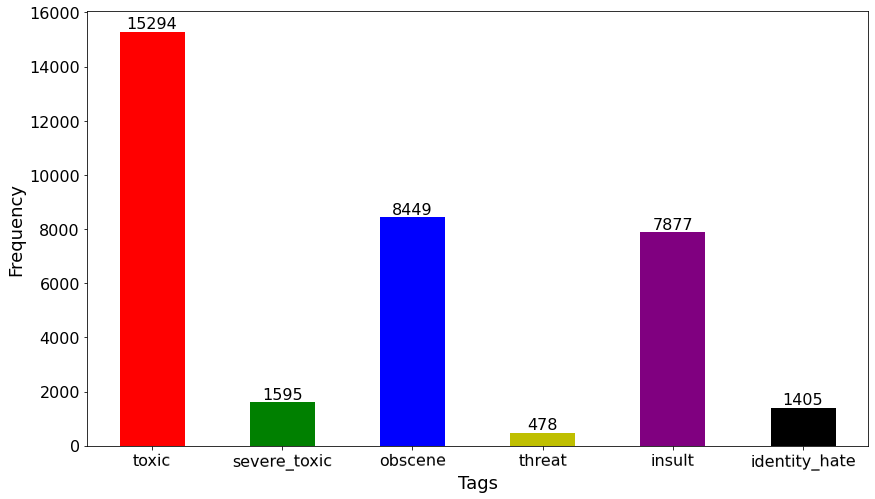

In [25]:
ax = train_data[["toxic","severe_toxic","obscene","threat","insult","identity_hate"]].sum().plot(kind='bar', rot=0.5, fontsize=16, color=['r','g','b','y','purple','black'], figsize=(14,8))

ax.set_xlabel("Tags",fontdict={'fontsize':18})
ax.set_ylabel("Frequency",fontdict={'fontsize':18})

for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2, p.get_height() + 5, p.get_height(), fontsize = 16, ha='center', va='bottom')

#### plot correlation between different categories

In [28]:
corr_mat = train_data.corr()
corr_mat.style.background_gradient(cmap='coolwarm')

In [31]:
stopwords = list(STOPWORDS)

#### Visualize common words in toxic comments

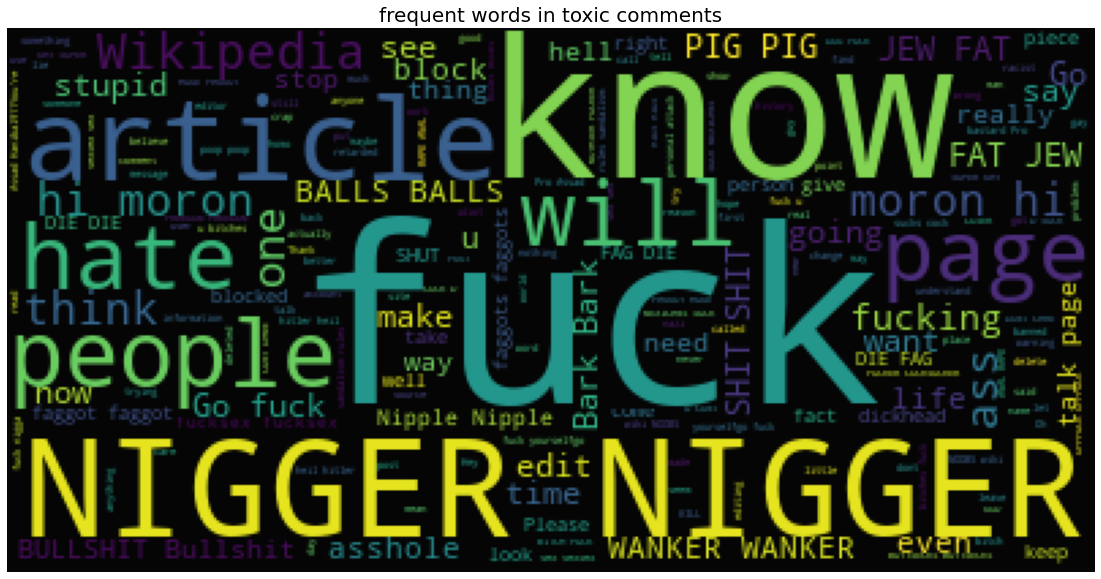

In [32]:
text=train_data[train_data.is_clean == 0].comment_text.values
wc_toxic = WordCloud(background_color="black",max_words=2000,stopwords=stopwords)
wc_toxic.generate(" ".join(text))
plt.figure(figsize=(20,10))
plt.axis("off")
plt.title("frequent words in toxic comments", fontsize=20)
plt.imshow(wc_toxic.recolor(colormap= 'viridis' , random_state=17), alpha=0.98)
plt.show()

#### Visualize common words in clean comments

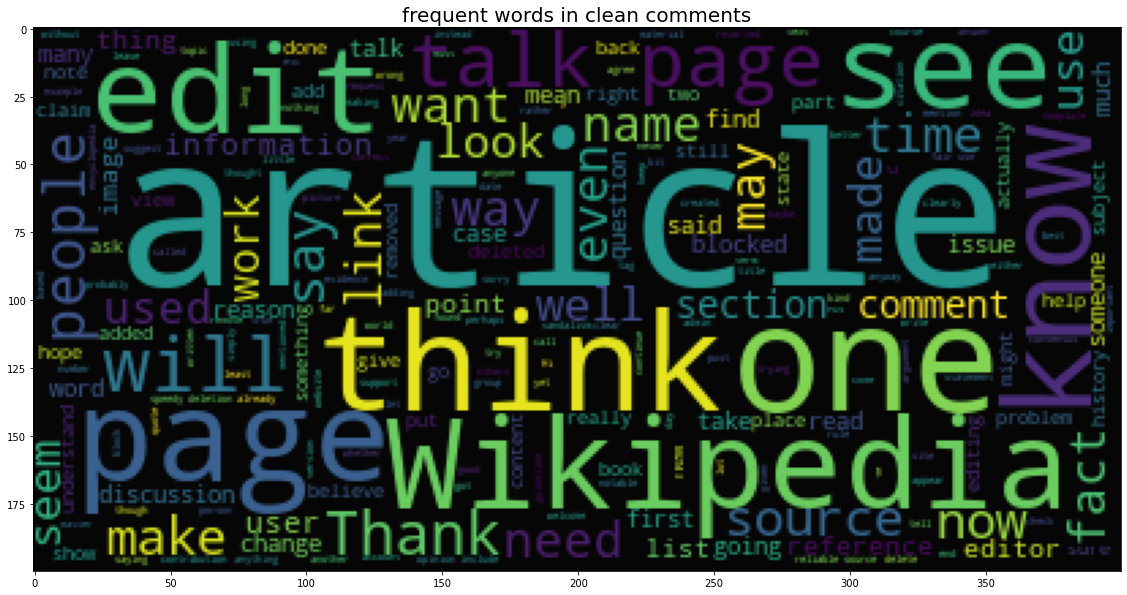

In [33]:
text=train_data[train_data.is_clean == 1].comment_text.values
wc_clean = WordCloud(background_color="black",max_words=2000,stopwords=stopwords)
wc_clean.generate(" ".join(text))
plt.figure(figsize=(20,10))
plt.title("frequent words in clean comments", fontsize=20)
plt.imshow(wc_clean.recolor(colormap= 'viridis' , random_state=17), alpha=0.98)
plt.show()

In [39]:
# get common words between two clean comments and toxic comments
common_words = list(set(wc_clean.words_.keys()) & set(wc_toxic.words_.keys()))
common_words[:30]

['policies',
 'majority',
 'general',
 'word',
 'actually',
 'waste',
 'willing',
 'whether',
 'u',
 'along',
 'sound',
 'test',
 'X',
 'internet',
 'Obama',
 'community',
 'Barnstar',
 'whose',
 'BTW',
 'find',
 'recent',
 'finally',
 'player',
 'normal',
 'will see',
 'put',
 'completely',
 'username',
 'e',
 'discussion page']

#### visualize toxic comments after removing common words with clean comments

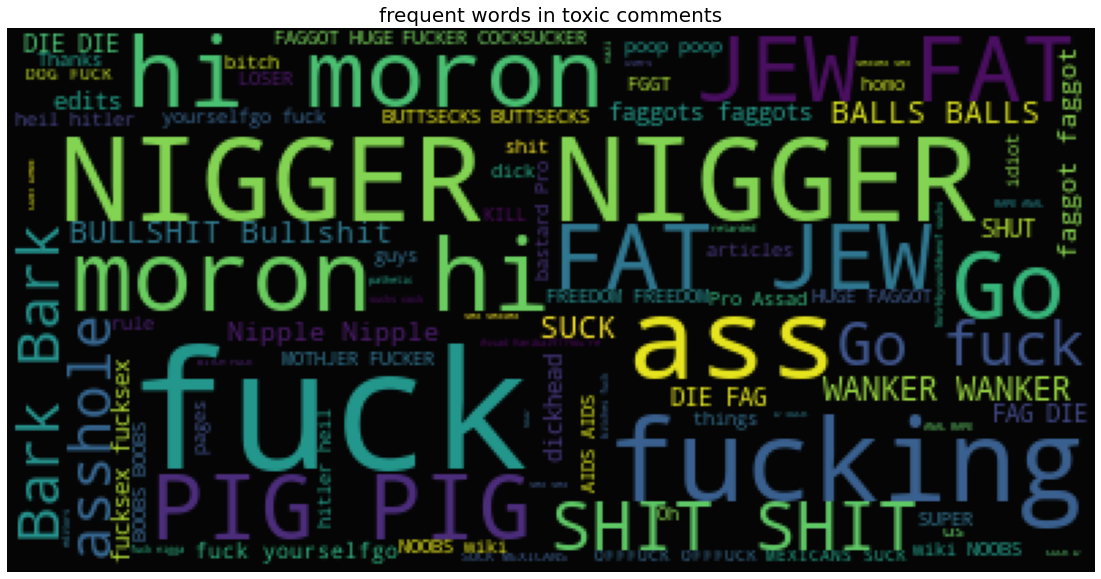

In [40]:
text=train_data[train_data.is_clean == 0].comment_text.values
wc_toxic_updated = WordCloud(background_color="black",max_words=2000,stopwords=stopwords+common_words)
wc_toxic_updated.generate(" ".join(text))
plt.figure(figsize=(20,10))
plt.axis("off")
plt.title("frequent words in toxic comments", fontsize=20)
plt.imshow(wc_toxic_updated.recolor(colormap= 'viridis' , random_state=17), alpha=0.98)
plt.show()

#### Visualize toxic (each subcategory) comments after removing common words

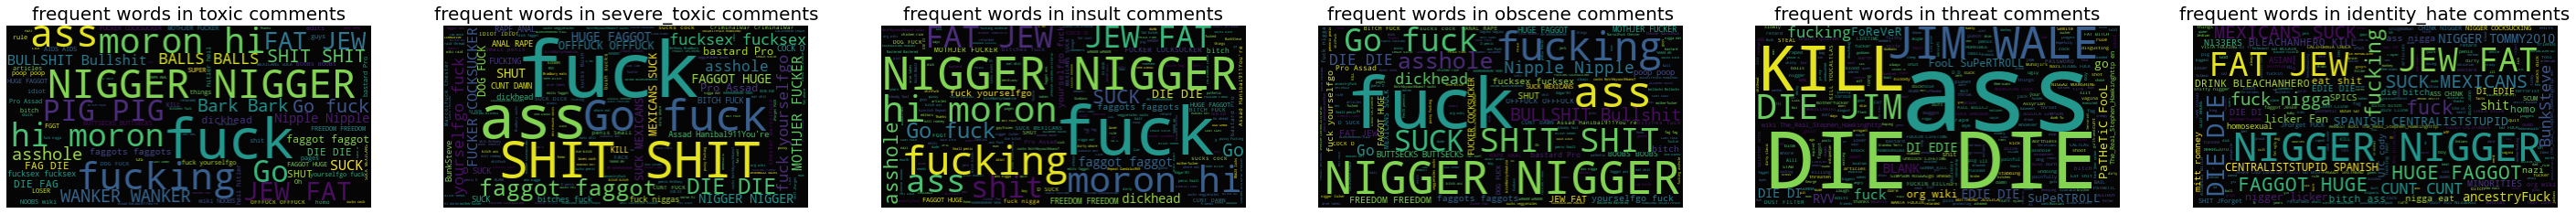

In [42]:

toxic_subcategories = ["toxic", "severe_toxic", "insult", "obscene", "threat", "identity_hate"]


fig, axs = plt.subplots(1,len(toxic_subcategories),figsize=(50,30))

i = 0
for category in toxic_subcategories:
    
    title = f"frequent words in {category} comments"
    
    text=train_data[train_data[category]==1].comment_text.values
    wc_subcategory = WordCloud(background_color="black",max_words=2000,stopwords=stopwords+common_words)
    wc_subcategory.generate(" ".join(text))
    axs[i].axis("off")
    axs[i].set_title(title, fontsize=20)
    axs[i].imshow(wc_subcategory.recolor(colormap= 'viridis' , random_state=17), alpha=0.98)
    
    i+=1

plt.show()

#### Extracting features from the textual data

In [43]:
# number of words per sentence
train_data['words_count']=train_data["comment_text"].apply(lambda x: len(str(x).split()))

# number of sentences per comment
train_data['sent_count']=train_data["comment_text"].apply(lambda x: len(re.split("\n|\.",str(x))))


# number of unique words
train_data['unique_words_count']=train_data["comment_text"].apply(lambda x: len(set(str(x).split())))

# average number of words/sentences per category
train_data["average_words_count"] = 0.0

for col in ["toxic",'severe_toxic','insult','threat','obscene','identity_hate','is_clean']:
    
    train_data.loc[train_data[col]==1,"average_words_count"] = train_data[train_data[col] == 1]["words_count"].sum()/len(train_data[train_data[col] == 1])
    
    
    train_data.loc[train_data[col]==1,"average_sent_count"] = train_data[train_data[col] == 1]["sent_count"].sum()/len(train_data[train_data[col] == 1])

<ipython-input-44-6f3616b6ff5d>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x)


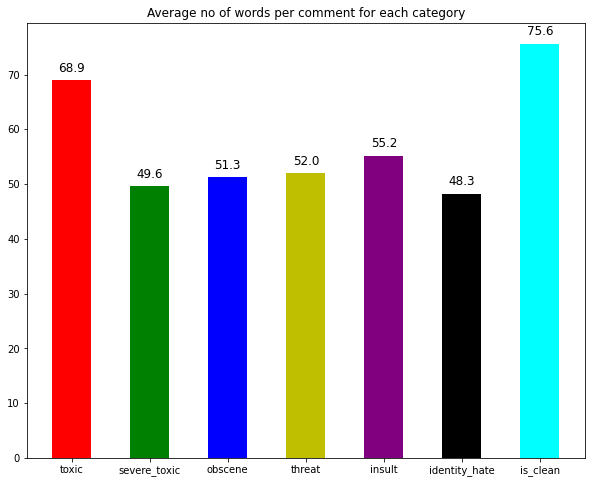

In [44]:
x = ["toxic","severe_toxic","obscene","threat","insult","identity_hate","is_clean"]
y = train_data["average_words_count"].unique()

fig, ax = plt.subplots(figsize=(10,8))

width = 0.5
ax.set_xticklabels(x)
ax.set_title("Average no of words per comment for each category")
ax.bar(x, y, width, color=['r','g','b','y','purple','black','cyan'])


for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2, p.get_height() + 1, round(p.get_height(),1), fontsize = 12, ha='center', va='bottom')

<ipython-input-45-93c17298f2f7>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x)


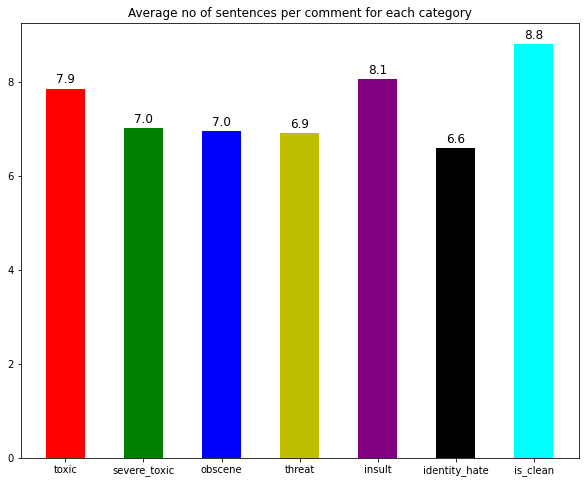

In [45]:
x = ["toxic","severe_toxic","obscene","threat","insult","identity_hate","is_clean"]
y = train_data["average_sent_count"].unique()

fig, ax = plt.subplots(figsize=(10,8))

width = 0.5
ax.set_xticklabels(x)
ax.set_title("Average no of sentences per comment for each category")
ax.bar(x, y, width, color=['r','g','b','y','purple','black','cyan'])


for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2, p.get_height() + 0.05, round(p.get_height(),1), fontsize = 12, ha='center', va='bottom')

##### Note: from the above visualizations, it seems that toxic comments tend to be shorter!

#### Extract links/ip from comments as features

In [52]:
train_data['ip']=train_data["comment_text"].apply(lambda x: re.findall("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}",str(x)))
train_data['link']=train_data["comment_text"].apply(lambda x: re.findall("http://.*com",str(x)))

#### Applying some text preprocessing steps

In [53]:
def prepare_text(comment):
    
    comment=comment.lower()
    #remove \n
    comment=re.sub("\\n","",comment)
    #remove ips
    comment=re.sub("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}","",comment)
    #remove numbers
    comment=re.sub("[0-9]"," ",comment)
    #remove non english letters
    comment=re.sub("[^a-zA-Z ]","",comment)
    #remove links
    comment=re.sub(".*com","",comment)
    #replace repeated characters with one character
    comment=re.sub(r"(.)\1{2,}",r"\1",comment)
    
    return ' '.join(comment.split())

In [54]:
train_data["clean_text"] = train_data["comment_text"].apply(lambda x: prepare_text(x))
train_data["clean_text_tokenized"] = train_data["clean_text"].apply(lambda x: x.split())

## Classification Model Development

#### Getting  Labels

In [56]:
binary_labels = train_data[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]]
binary_labels.head()

toxic  severe_toxic  obscene  threat  insult  identity_hate
0      0             0        0       0       0              0
1      0             0        0       0       0              0
2      0             0        0       0       0              0
3      0             0        0       0       0              0
4      0             0        0       0       0              0

In [57]:
#### Using TF-IDF Algorithm for feature extraction

In [58]:
tf_vectorizer = TfidfVectorizer(min_df=100,analyzer='word',strip_accents='unicode',
                      ngram_range=(1,1),use_idf=1,smooth_idf=1,
                      stop_words = 'english')

In [63]:
from sklearn.model_selection import train_test_split

#### Using Words_Count as an extra feature along with textual feautures

In [64]:
features = train_data[["clean_text","words_count"]]
features.head()

clean_text  words_count
0  explanationwhy the edits made under my usernam...           43
1  daww he matches this background colour im seem...           17
2  hey man im really not trying to edit war its j...           42
3  morei cant make any real suggestions on improv...          113
4  you sir are my hero any chance you remember wh...           13

#### Dataset splitting
#### Splitting Training Dataset into Training set and validation set (for metrics calculation and hyperparameter tuning)

In [72]:
xtrain, xval, ytrain, yval = train_test_split(features, binary_labels, test_size=0.2, random_state=20)

#### Create TF-IDF features

In [73]:
xtrain_tfidf = tf_vectorizer.fit_transform(xtrain["clean_text"])
xval_tfidf = tf_vectorizer.transform(xval["clean_text"])

In [74]:
x_train_words_count = np.array(xtrain["words_count"]).reshape(-1,1)

In [75]:
x_train_words_count.shape

(127656, 1)

#### Stacking tf-idf features and words_count features horizontally

In [76]:
from scipy.sparse import hstack

x_train_processed = hstack((xtrain_tfidf,np.array(xtrain['words_count'])[:,None]))

In [77]:
x_val_processed = hstack((xval_tfidf,np.array(xval['words_count'])[:,None]))

### Model selection and hyperparamter tuning
#### Model selection is based on K-fold cross-validation with K = 5

In [81]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

param_grid = {'estimator__max_depth': [None, 3, 10, 20],'estimator__min_samples_leaf': [1,5,10,20], 'estimator__min_samples_split': [2, 5, 10, 20]}

#Run RandomForestClassifier
classifier = RandomForestClassifier()
multi_classifier = OneVsRestClassifier(classifier)

# fit model on train data
#multi_classifier.fit(x_train_processed, ytrain)

grid_search = GridSearchCV(multi_classifier, param_grid, cv=5).fit(x_train_processed, ytrain)

#### Evaluate Model on validation set

In [ ]:
# make predictions for validation set
predictions = grid_search.predict(x_val_processed)

# evaluate performance
from sklearn.metrics import accuracy_score
print("Accuracy score for Classifier:")
print(accuracy_score(yval, predictions))

Accuracy score for Classifier:
0.9117342942190193


#### Best parameters according to the Grid Search

In [ ]:
grid_search.best_params_

{'estimator__max_depth': None,
 'estimator__min_samples_leaf': 5,
 'estimator__min_samples_split': 2}

## Testing Model on Testset

#### Unzip and load test_data

In [ ]:
!unzip /content/test_labels.csv.zip

Archive:  /content/test_labels.csv.zip
  inflating: test_labels.csv         


In [ ]:
test_data = pd.read_csv('/content/test_labels.csv')
test_data.tail()

id  toxic  severe_toxic  ...  threat  insult  identity_hate
153159  fffcd0960ee309b5     -1            -1  ...      -1      -1             -1
153160  fffd7a9a6eb32c16     -1            -1  ...      -1      -1             -1
153161  fffda9e8d6fafa9e     -1            -1  ...      -1      -1             -1
153162  fffe8f1340a79fc2     -1            -1  ...      -1      -1             -1
153163  ffffce3fb183ee80     -1            -1  ...      -1      -1             -1

[5 rows x 7 columns]

#### Applying same transformations done to training data

In [ ]:
test_data["clean_text"] = test_data["comment_text"].apply(lambda x: prepare_text(x))
test_data['words_count']=test_data["comment_text"].apply(lambda x: len(str(x).split()))

In [ ]:
test_tfidf = tf_vectorizer.transform(test_data["clean_text"])

In [ ]:
test_processed = hstack((test_tfidf,np.array(test_data['words_count'])[:,None]))

In [ ]:
predictions = multi_classifier.predict(test_processed)

In [ ]:
predictions

array([[1, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 1, 0]])

In [83]:
#### Extracting predicitions to CSV file

In [ ]:
pred = pd.DataFrame(i for i in predictions)

In [ ]:
df = pd.DataFrame()
df["id"] = test_data["id"]
df = df.join(pred)

In [ ]:
df = df.rename(columns={0: "toxic", 1: "severe_toxic", 2: "obscene", 3: "threat", 4: "insult", 5: "identity_hate"},errors="raise")

In [ ]:
df.to_csv("predictions.csv", index=False)